## Learning diffusivity (m) to solution (u) map for Poisson problem (Implementation 2)

Data is located in `../data` directory, and key data of our interest is in `Poisson_samples.npz` file. We would also need the mesh data in files with names `Poisson_m_mesh` and `Poisson_u_mesh` for plotting.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results/neural_operator_prediction_comparison.png" width="800"> </p>

In [ ]:
import sys
import os

import torch
import numpy as np


src_path = "../../../../src/"
sys.path.append(src_path + 'plotting/')
from field_plot import field_plot
from plot_loss import plot_loss
from plot_svd import plot_s_vec_values

sys.path.append(src_path + 'data/')
from dataMethods import DataProcessor

sys.path.append(src_path + 'nn/pcanet/')
sys.path.append(src_path + 'nn/mlp/') # need this here so that PCANet can be imported (it imports MLP)
from torch_pcanet import PCANet

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
data_folder = '../data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [4]:
num_train = 3500
num_test = 1000

num_inp_fn_points = 2601 # number of grid points for the input function
num_out_fn_points = 2601 # number of evaluations points for the output function
num_Y_components = 1 # scalar field
num_inp_red_dim = 100 # number of reduced dimensions for the input data
num_out_red_dim = 100 # number of reduced dimensions for the output data
out_coordinate_dimension = 2 # domain for output function is 2D

# training hyperparameters
batch_size = 20
epochs = 1000
lr = 1.0e-3
act_fn = torch.relu

data_prefix = 'Poisson'
data = DataProcessor(data_folder + data_prefix + '_samples.npz', num_train, num_test, num_inp_fn_points, num_out_fn_points, num_Y_components, num_inp_red_dim, num_out_red_dim)

train_data = {'X_train': data.X_train, 'X_trunk': data.X_trunk, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'X_trunk': data.X_trunk, 'Y_train': data.Y_test}

# get data to save
data_to_save = data.get_data_to_save()

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)
print('X_trunk:',data.X_trunk.shape)

print('X_train_svd_projector:',data.X_train_svd_projector.shape)
print('Y_train_svd_projector:',data.Y_train_svd_projector.shape)

X_train: (3500, 100)
Y_train: (3500, 100)
X_test: (1000, 100)
Y_test: (1000, 100)
X_trunk: (2601, 2)
X_train_svd_projector: (100, 2601)
Y_train_svd_projector: (100, 2601)


### Plot singular values

j = 0, i = 0, index = 100, index_val = 0.03291448846980946
j = 0, i = 1, index = 100, index_val = 0.003337089766637408
j = 1, i = 0, index = 35, index_val = 0.09997674399160754
j = 1, i = 1, index = 10, index_val = 0.10808882910481311
j = 2, i = 0, index = 289, index_val = 0.01001621388222059
j = 2, i = 1, index = 49, index_val = 0.010074988092343607


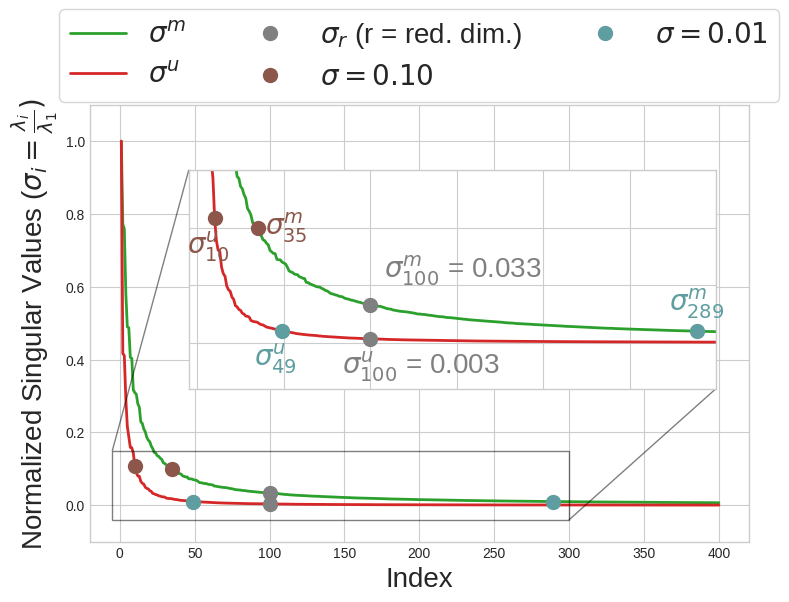

In [7]:
plot_annot_xy = [0.15, 0.35, 0.8, 0.5]
plot_annot_xy_region = [-5, 300, -0.04, 0.15]
xy_text_vec = []
xy_text_vec.append([(10, 20), (-20, -25)])
xy_text_vec.append([(5, -5), (-20, -25)])
xy_text_vec.append([(-20, 15), (-20, -25)])
l_style_vec = ['-', '-']
plot_s_vec_values([data.X_train_s_values, data.Y_train_s_values], [num_inp_red_dim, num_out_red_dim], \
                    ['m', 'u'], \
                    l_style_vec, \
                    xy_text_vec, \
                    plot_annot_xy, \
                    plot_annot_xy_region, \
                    results_dir + data_prefix + '_svd_analysis_m_u')

## Create model and train the network

In [8]:
num_layers = 4
num_neurons = 250
model_save_path = results_dir
model_save_file = model_save_path + 'model.pkl'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model = PCANet(num_layers, num_neurons, act_fn, \
               num_inp_red_dim, num_out_red_dim, \
               save_file = model_save_file)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: {}'.format(trainable_params))

Number of trainable parameters: 175850


In [9]:
# save the data and info
data_to_save = data.get_data_to_save()
model_metadata = {  'data': data_to_save, \
                    'num_train': num_train, \
                    'num_test': num_test, \
                    'num_inp_fn_points': num_inp_fn_points, \
                    'num_out_fn_points': num_out_fn_points, \
                    'num_Y_components': num_Y_components, \
                    'out_coordinate_dimension': out_coordinate_dimension, \
                    'num_inp_red_dim': num_inp_red_dim, \
                    'num_out_red_dim': num_out_red_dim, \
                    'num_layers': num_layers, \
                    'num_neurons': num_neurons, \
                    'epochs': epochs, \
                    'batch_size': batch_size, \
                    'lr': lr}

# attach it to the model
model.metadata = model_metadata


In [10]:
# Train
model.train(train_data, test_data, batch_size=batch_size, \
            epochs = epochs, lr = lr, \
            save_model = True, save_epoch = 100)

--------------------------------------------------
Starting training with 175850 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 5.442e+00, Test Loss (l2 squared): 1.766e+00, Time (sec): 1.017
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 1.433e-01, Test Loss (l2 squared): 2.808e-01, Time (sec): 0.863
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 6.650e-02, Test Loss (l2 squared): 2.140e-01, Time (sec): 1.107
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 200
----

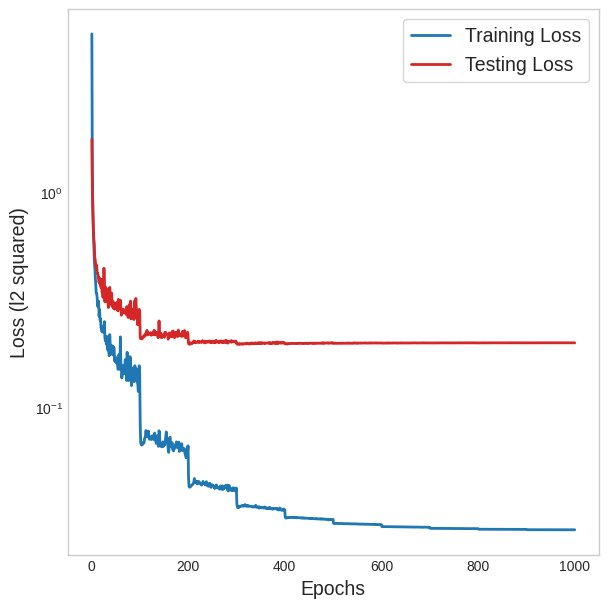

In [11]:
## Plotting the loss history

plot_loss( model.train_loss_log[:, 0], \
           model.test_loss_log[:, 0], \
           fs = 14, lw = 2, \
           savefile = results_dir+'loss_his.png', \
           figsize = [6,6])

# Save the model

In [12]:
# not needed as the model will be saved at the end of training
torch.save(model, model_save_file)

## Test and plot the output of network

In [13]:
# load the model
model = torch.load(model_save_file, weights_only=False)

sfname = model_save_file.split(os.path.sep)
print('-'*50)
print('Model loaded from: {}'.format(sfname[-2] + '/' + sfname[-1]))
print('\n' + '-'*50)
print('Model metadata:', model.metadata.keys())
print('\n' + '-'*50)
print('Model:', model)

--------------------------------------------------
Model loaded from: Results/model.pkl

--------------------------------------------------
Model metadata: dict_keys(['data', 'num_train', 'num_test', 'num_inp_fn_points', 'num_out_fn_points', 'num_Y_components', 'out_coordinate_dimension', 'num_inp_red_dim', 'num_out_red_dim', 'num_layers', 'num_neurons', 'epochs', 'batch_size', 'lr'])

--------------------------------------------------
Model: PCANet(
  (net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=100, out_features=250, bias=True)
      (1-2): 2 x Linear(in_features=250, out_features=250, bias=True)
      (3): Linear(in_features=250, out_features=100, bias=True)
    )
  )
)


In [14]:
Y_test = test_data['Y_train']
Y_test_pred = model.predict(test_data['X_train']).detach().numpy()

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

error = np.linalg.norm(Y_test - Y_test_pred, axis = 1)/np.linalg.norm(Y_test, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (1000, 100), test_pred shape: (1000, 100)
Num tests:  1000, Mean Loss (rel l2): 1.051e-01, Std Loss (rel l2): 3.714e-02


In [15]:
def apply_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids] = bc_value
    return u

i_plot =    18, error (rel l2): 8.752e-03
i_plot =   939, error (rel l2): 1.336e-02
i_plot =   532, error (rel l2): 6.348e-03
i_plot =   671, error (rel l2): 1.288e-02


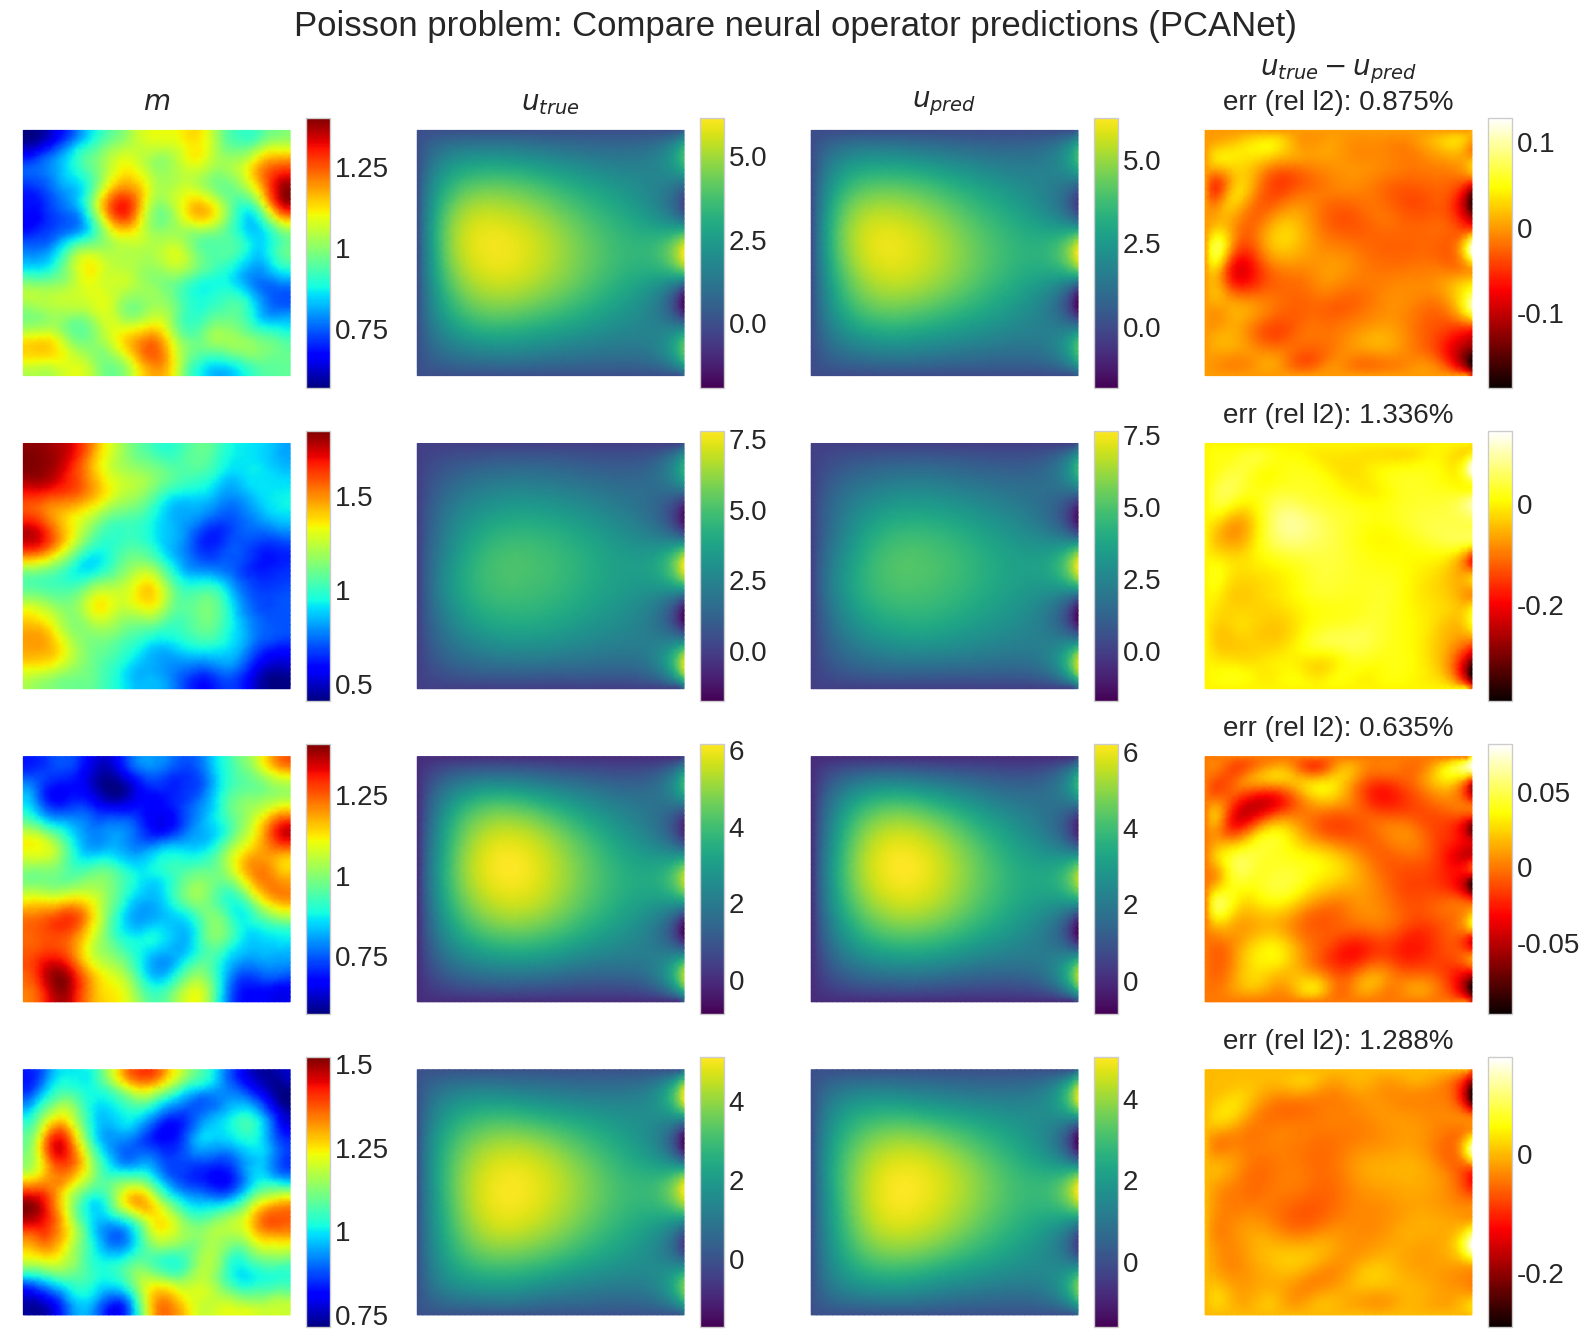

In [17]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True
apply_dirichlet_bc_flag = True

# row: m, u_true, u_pred, u_diff
u_tags = [r'$m$', r'$u_{true}$', r'$u_{pred}$', r'$u_{true} - u_{pred}$']
cmaps = ['jet', 'viridis', 'viridis', 'hot']

nodes = data.X_trunk 

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)
        i_truth = data.decoder_Y(i_truth)
        i_m_test = data.decoder_X(i_m_test)
    if apply_dirichlet_bc_flag:
        i_pred = apply_dirichlet_bc(i_pred, 0.0, data.u_mesh_dirichlet_boundary_nodes)
        # verify for i_truth
        if np.abs(i_truth[data.u_mesh_dirichlet_boundary_nodes]).max() > 1.0e-9:
            print('Warning: Dirichlet BC not applied to i_truth. Err : {}'.format(np.abs(i_truth[data.u_mesh_dirichlet_boundary_nodes]).max()))
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        
        cbar = field_plot(axs[i,j], uvec[j], nodes, cmap = cmaps[j])

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm*100)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Poisson problem: Compare neural operator predictions ({})'.format(model.name), fontsize=1.25*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()
